# Survival Analysis: LUAD Alternative Outcomes

Survival Analysis is most often used with survival data (deceased vs. living), but has many diverse applications when determining the risk of some event occurring. Here, we will look at the risk of tumor recurrence based on protein expression data.

In [1]:
import pandas as pd
import cptac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

## Step 1: Import Follow-up and Protein Data

In [2]:
luad = cptac.Luad()
follow_up = luad.get_followup()
proteomics = luad.get_proteomics()

cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


Then reduce the complexity of the indices for the protein data

In [3]:
proteomics = luad.reduce_multiindex(proteomics, levels_to_drop="Database_ID")

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


# Here are the functions that will be used throughout this demo notebook.
**Note: Not all of these functions will be relevant in cptac/utils

In [4]:
'ACP1' in set(proteomics['ACP1'].columns)

True

In [5]:
def plotBasicKaplanMeier(time_col, status_col, df):
    '''
    Parameters:
        Timeframe (time_col; You provide the name of the column. It must contain numeric data)
        Event of interest (status_col; You provide the name of the column. It must contain boolean data)
    
    It will then plot a basic Kaplan Meier plot for your cohort based on the time and
    event data you provided it.
    '''
    time = df[time_col]
    status = df[status_col]

    kmf = KaplanMeierFitter()
    kmf.fit(time, event_observed = status)
    kmf.plot()

def plotMultivariateKaplanMeier(df, time_col, status_col, cancer, list_to_fill, print_summary):
    '''
    Parameters
        df (DataFrame*)
        time_col (Type = string; name of column containing time to event occurrence)
        status_col (Type = string; name of column containing boolean values for the event of interest)
        cancer (Type = cptac cancer object; i.e. cptac.Endometrial())
        list_to_fill (Type = list of string names of genes; This will be populated with 
        significant genes found when performing Cox's Proportional Hazard Test)
        print_summary (Type = bool; "True" will print the results of a 
        proportional hazard test for the attribute(s) you are researching)
    
    *The DataFrame must be formatted according to the following requirements
    for this function to execute properly:
        A column must contain boolean values for an event of interest (True = the event occurred)
        A numeric column indicating time until the event occurred or until last contact
        Numeric columns for other attributes you are researching (i.e. protein abundance)
        
    '''
    cph = CoxPHFitter()
    cph.fit(df, duration_col = time_col, event_col = status_col)
    results = proportional_hazard_test(cph, df, time_transform='rank')
    if print_summary:
        results.print_summary(decimals=3, model="untransformed variables")
    results_df = results.summary
    risk_genes = list(results_df[results_df['p'] < .05].index)
    if len(risk_genes) > 0:
        for attribute in risk_genes:
            list_to_fill.append(attribute)
            cph.plot_covariate_groups(attribute, [0,1, 2], cmap='coolwarm', 
                                      title=cancer.get_cancer_type().upper() + " Cancer " 
                                      + status_col + " Risk: " + attribute)

def splitGeneByExpression(gene, df):
    '''
    Parameters:
        gene (Type = String; name of gene you want to split by expression)
        df (DataFrame containing a column that corresponds to the gene)
        
    This function will split expression data into 3 categories, which will make
    Cox's Proportional Hazard Test and Multivariate Kaplan Meier plots possible.
    It splits based on quantiles (the lowest 25% = 1, middle 50% = 2, and upper 25% = 3)
    which can then be used to easily plot Multivariate Kaplan Meier plots and
    perform Cox's Proportional Hazard Test.  
    
    Return:
    It will return a new, modified DataFrame containing these changes, that can 
    then be used in plotMultivariateKaplanMeier().
    '''
    df_genes = df.copy()
    col_set = set(df_genes.columns)
    duplicates = set()
    new_list = []
    if (len(col_set) != len(df_genes.columns)):
        for i, gene in enumerate(df_genes.columns):
            if gene in duplicates:
                new_gene_name = gene + "(" + str(i) + ")"
                new_list.append(new_gene_name)
            else:
                new_list.append(gene)
                duplicates.add(gene)
        df_genes.columns = new_list
    gene_list = list(df_genes.columns)
    for gene in gene_list:
        lower_25_filter = df_genes[gene] <= df_genes[gene].quantile(.25)
        upper_25_filter = df_genes[gene] >= df_genes[gene].quantile(.75)

        df_genes[gene] = np.where(lower_25_filter, "Lower_25%", df_genes[gene])
        df_genes[gene] = np.where(upper_25_filter, "Upper_25%", df_genes[gene])
        df_genes[gene] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[gene])


        proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
        df_genes[gene] = df_genes[gene].map(proteomics_map)
    df_genes = df_genes.dropna(axis=0, how='any')
    return df_genes.copy()

def mergeDFs(df_genes, follow_up_df, gene, 
             time_to_event, time_to_last_contact, event_of_interest):
    '''
    Parameters:
        df_genes (DataFrame of genetic data; i.e. proteomics, transcriptomics, etc.)
        follow_up_df (DataFrame of follow_up data; can be obtained by calling get_followup() 
        on a cptac cancer object such as cptac.Luad())
        gene (Type = String; Name of gene you want to test. This will be a column in df_genes
        that you want to merge with follow_up_df)
        time_to_event (Type = String; Name of column in follow_up_df containing numeric data 
        of the number of days until the event of interest occurs. Can contain NaN)
        time_to_last_contact (Type = String; Name of column in follow_up_df containing numeric 
        data of the number of days until last contact with each patient. Can contain NaN)
        event_of_interest (Type = String; Name of column in follow_up_df containing boolean data 
        of the the event of interest occurs. True = the event occurred; False = it did not occur)
    Return:
        A new DataFrame (final_df) that is the result of merging 'df_genes' and 'follow_up_df' on 'gene'.
    '''
    cols = [time_to_event, time_to_last_contact]
    new_df = follow_up_df.copy()
    new_df = new_df.assign(Days_Until_Last_Contact_Or_New_Event=new_df[cols].sum(1)).drop(cols, 1)
    
    cols_of_interest = [event_of_interest, 'Days_Until_Last_Contact_Or_New_Event']
    
    final_df = pd.merge(new_df[cols_of_interest], 
                        df_genes[gene], 
                        left_on=new_df[cols_of_interest].index, 
                        right_on=df_genes[gene].index)
    
    final_df.index = final_df['key_0']
    final_df = final_df.drop("key_0", axis=1)
    return final_df

def rapidTTest(merged_df, gene, results_dict, event):
    '''
    Parameters:
        merged_df (DataFrame merged by mergeDFs(); see mergeDFs() for more details)
        gene (Type = String; name of gene you want to perform a t-test on)
        results_dict (Type = dictionary; this dictionary will be populated with 
        genes as keys and p-values as values)
        event (Type = String; name of event you are testing against the genes; 
        i.e. is there a significant difference in TP53 expression for people with 
        tumor recurrence vs. tumor remission)
    '''
    no_event = merged_df[merged_df[event] == False]
    yes_event = merged_df[merged_df[event] == True]
    stat, p_val = scipy.stats.ttest_ind(yes_event[gene], no_event[gene])
    if (isinstance(p_val, float)):
        if p_val < 0.05:
            results_dict[gene] = p_val
    else:
        to_add = set()
        for val in p_val:
            if (isinstance(val, float)):
                if val < 0.05:
                    to_add.add(val)
        if len(to_add) > 0:
            results_dict[gene] = min(to_add)

For Cox's Proportional Hazard test and Kaplan Meier Plotting, the column containing the event of interest (in this case 'New Tumor After Initial TRT') must contain boolean values, where True maps to the event occurring, and False maps to it not occurring

In [6]:
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].replace('No', False)
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].replace('Yes', True)
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].astype(bool)

Lastly, we will run our functions with the correct parameters as stated in the docstrings for the functions up a few cells from here.  It is crucial that we give the correct columns for time_to_event, time_to_last_contact, and event_of_interest, as they are referenced often in the functions

# Step 2: Perform T-Tests for each Gene 
First, we will perform t-tests for each gene to determine if there is a significant difference in protein expression between patients who had tumor recurrence and those that did not.  Those genes and p-values will be stored in 'results_dict'.

In [7]:
time_to_event = 'Path Diag to new Tumor days'
time_to_last_contact = 'Path Diag to Last Contact(Day)'
event_of_interest = 'New Tumor After Initial TRT'
genes = list(proteomics.columns)
results_dict = {}
for gene in genes:
    merged_df = mergeDFs(proteomics, follow_up, gene, 
             time_to_event, time_to_last_contact, event_of_interest)
    rapidTTest(merged_df, gene, results_dict, event_of_interest)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Next, we will convert our results to a dataframe, and filter out any genes that did not have significant p-values, so that we can use those to perform Cox's Proportional Hazard Test and make Kaplan Meier plots

In [11]:
test_df = pd.DataFrame(results_dict, index = range(0,1))
test_df = test_df.T
all_sigs = test_df[test_df[0] < 0.05]
sig_genes = list(all_sigs.index)

# Step 3: Use the significant genes to perform Cox's Proportional Hazard Test and make Kaplan Meir Plots
*Note:* Kaplan Meier plots are shown only for the genes that were significant based on both the t-tests above and the proportional hazard test below

<lifelines.StatisticalResult: AAGAB>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
AAGAB           0.748 0.387     1.369
<lifelines.StatisticalResult: AAMP>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
AAMP           0.094 0.759     0.398
<lifelines.StatisticalResult: ABCA1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
ABCA1           0.101 0.751     0.414
<lifelines.StatisticalResult: ABHD13>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution =

<lifelines.StatisticalResult: AHSP>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
AHSP           0.359 0.549     0.865
<lifelines.StatisticalResult: AKAP17A>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
AKAP17A           0.138 0.710     0.494
<lifelines.StatisticalResult: AKAP9>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
AKAP9           0.040 0.841     0.249
<lifelines.StatisticalResult: AKR1B10>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distrib

<lifelines.StatisticalResult: ARHGEF28>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
          test_statistic     p  -log2(p)
ARHGEF28           0.650 0.420     1.252
<lifelines.StatisticalResult: ARID4A>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
ARID4A           5.516 0.019     5.730
<lifelines.StatisticalResult: ARNT>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
ARNT           0.365 0.546     0.873
<lifelines.StatisticalResult: ASAP2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_dis

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
CA2              3.995 0.046     4.454
CA2(3)           0.392 0.531     0.913
<lifelines.StatisticalResult: CAAP1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
CAAP1           0.158 0.691     0.533
<lifelines.StatisticalResult: CAB39L>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
CAB39L           0.767 0.381     1.391
<lifelines.StatisticalResult: CACNA2D2>
         test_name = proportional_hazard_test
    

<lifelines.StatisticalResult: CFL2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
CFL2           2.278 0.131     2.930
<lifelines.StatisticalResult: CGN>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
     test_statistic     p  -log2(p)
CGN           0.008 0.931     0.103
<lifelines.StatisticalResult: CHID1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
CHID1           3.357 0.067     3.902
<lifelines.StatisticalResult: CIAO2A>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi s

<lifelines.StatisticalResult: CST3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
CST3           0.017 0.896     0.159
<lifelines.StatisticalResult: CSTB>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
CSTB           1.013 0.314     1.670
<lifelines.StatisticalResult: CTPS2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
CTPS2           0.000 1.000     0.000
<lifelines.StatisticalResult: CTTN>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi 

<lifelines.StatisticalResult: DNAAF5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
DNAAF5           2.901 0.089     3.498
<lifelines.StatisticalResult: DNAH11>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
DNAH11           0.014 0.907     0.141
<lifelines.StatisticalResult: DNAH12>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
DNAH12           2.249 0.134     2.903
<lifelines.StatisticalResult: DOCK6>
         test_name = proportional_hazard_test
    time_transform = rank
 null_dis

<lifelines.StatisticalResult: ERLEC1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
ERLEC1           0.168 0.682     0.552
<lifelines.StatisticalResult: ESS2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
ESS2           0.071 0.790     0.341
<lifelines.StatisticalResult: EVPL>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
EVPL           0.391 0.532     0.912
<lifelines.StatisticalResult: EXOC5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = 

<lifelines.StatisticalResult: FKBP11>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
FKBP11           1.238 0.266     1.912
<lifelines.StatisticalResult: FKBP1A>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
FKBP1A           0.005 0.943     0.084
<lifelines.StatisticalResult: FKBP5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
FKBP5           0.349 0.555     0.850
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution 

<lifelines.StatisticalResult: GNG2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
GNG2           0.002 0.968     0.046
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
           test_statistic     p  -log2(p)
GOLGB1              0.145 0.704     0.507
GOLGB1(3)           1.485 0.223     2.165
GOLGB1(4)           0.502 0.478     1.064
<lifelines.StatisticalResult: GON7>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
GON7           1.032 0.310     1.692
<lifelines.StatisticalResult: GORASP2>
         

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
           test_statistic     p  -log2(p)
HNRNPR              0.156 0.693     0.530
HNRNPR(3)           0.075 0.785     0.350
<lifelines.StatisticalResult: HOMER1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
HOMER1           3.687 0.055     4.189
<lifelines.StatisticalResult: HOOK3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
HOOK3           0.400 0.527     0.924
<lifelines.StatisticalResult: HPF1>
         test_name = proportional_hazard_test

<lifelines.StatisticalResult: ITGA4>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
ITGA4           0.511 0.475     1.075
<lifelines.StatisticalResult: ITGB6>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
ITGB6           0.806 0.369     1.437
<lifelines.StatisticalResult: ITPA>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
ITPA           0.062 0.804     0.315
<lifelines.StatisticalResult: ITPKB>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = 

<lifelines.StatisticalResult: LLGL2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
LLGL2           0.066 0.797     0.327
<lifelines.StatisticalResult: LMAN2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
LMAN2           0.310 0.577     0.792
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
LMO7              0.068 0.794     0.332
LMO7(3)           0.228 0.633     0.660
<lifelines.StatisticalResult: LPL>
         test_name = proportional_hazard_test
    time_

<lifelines.StatisticalResult: MICALL2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
MICALL2           2.482 0.115     3.118
<lifelines.StatisticalResult: MICU1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
MICU1           0.012 0.915     0.129
<lifelines.StatisticalResult: MICU2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
MICU2           0.011 0.917     0.125
<lifelines.StatisticalResult: MINK1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distri

<lifelines.StatisticalResult: NCOA7>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
NCOA7           0.311 0.577     0.793
<lifelines.StatisticalResult: NDEL1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
NDEL1           5.876 0.015     6.026
<lifelines.StatisticalResult: NDUFA12>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
NDUFA12           0.083 0.773     0.371
<lifelines.StatisticalResult: NDUFA13>
         test_name = proportional_hazard_test
    time_transform = rank
 null_dist

<lifelines.StatisticalResult: NOP58>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
NOP58           2.739 0.098     3.352
<lifelines.StatisticalResult: NPM3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
NPM3           0.444 0.505     0.985
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
NPNT              0.118 0.731     0.452
NPNT(3)           0.000 0.995     0.007
<lifelines.StatisticalResult: NPR3>
         test_name = proportional_hazard_test
    time_tr

<lifelines.StatisticalResult: PAK1IP1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
PAK1IP1           1.882 0.170     2.555
<lifelines.StatisticalResult: PAK4>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
PAK4           2.369 0.124     3.014
<lifelines.StatisticalResult: PAN3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
PAN3           0.407 0.523     0.934
<lifelines.StatisticalResult: PANK4>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
          test_statistic     p  -log2(p)
PLIN3              0.004 0.948     0.077
PLIN3(3)           0.245 0.620     0.689
<lifelines.StatisticalResult: PLS1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
PLS1           0.001 0.975     0.037
<lifelines.StatisticalResult: PLSCR3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
PLSCR3           0.039 0.844     0.245
<lifelines.StatisticalResult: PLXNC1>
         test_name = proportional_hazard_test
   

<lifelines.StatisticalResult: PTPN9>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
PTPN9           0.143 0.705     0.504
<lifelines.StatisticalResult: PUDP>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
PUDP           0.000 0.984     0.023
<lifelines.StatisticalResult: PUS3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
PUS3           1.984 0.159     2.653
<lifelines.StatisticalResult: PUS7>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi 

<lifelines.StatisticalResult: RIDA>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
RIDA           0.799 0.371     1.429
<lifelines.StatisticalResult: RIOK1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
RIOK1           1.376 0.241     2.054
<lifelines.StatisticalResult: RIPOR1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
RIPOR1           0.564 0.453     1.144
<lifelines.StatisticalResult: RIT1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution 

<lifelines.StatisticalResult: S100A4>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
S100A4           0.286 0.593     0.754
<lifelines.StatisticalResult: S100A6>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
S100A6           2.439 0.118     3.079
<lifelines.StatisticalResult: S100P>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
S100P           1.187 0.276     1.857
<lifelines.StatisticalResult: SAFB>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distrib

<lifelines.StatisticalResult: SHTN1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
SHTN1           0.053 0.818     0.290
<lifelines.StatisticalResult: SIAE>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
SIAE           2.744 0.098     3.356
<lifelines.StatisticalResult: SLC12A6>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
SLC12A6           0.070 0.791     0.339
<lifelines.StatisticalResult: SLC1A5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribu

<lifelines.StatisticalResult: SQLE>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
SQLE           0.609 0.435     1.200
<lifelines.StatisticalResult: SQOR>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
SQOR           1.586 0.208     2.266
<lifelines.StatisticalResult: SRC>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
     test_statistic     p  -log2(p)
SRC           0.560 0.454     1.138
<lifelines.StatisticalResult: SRGAP1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squa

<lifelines.StatisticalResult: TANK>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
TANK           1.361 0.243     2.039
<lifelines.StatisticalResult: TARBP2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
TARBP2           0.674 0.412     1.280
<lifelines.StatisticalResult: TARDBP>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
TARDBP           1.643 0.200     2.322
<lifelines.StatisticalResult: TASP1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribut

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: TBC1D9>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
TBC1D9           0.112 0.738     0.439
<lifelines.StatisticalResult: TBL1XR1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TBL1XR1           0.377 0.539     0.891
<lifelines.StatisticalResult: TELO2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
TELO2           0.104 0.747     0.421
<lifelines.StatisticalResult: TFDP1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_dis

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: TGFB1I1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TGFB1I1           0.311 0.577     0.793
<lifelines.StatisticalResult: THUMPD1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
THUMPD1           0.527 0.468     1.095
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TJP1              0.291 0.589     0.763
TJP1(3)           0.005 0.942     0.087
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
  

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: TKFC>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
TKFC           0.000 0.995     0.007
<lifelines.StatisticalResult: TLDC1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
TLDC1           0.803 0.370     1.434
<lifelines.StatisticalResult: TMED5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
TMED5           0.004 0.949     0.076
<lifelines.StatisticalResult: TMED8>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = 

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: TP53BP2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TP53BP2           0.282 0.595     0.749
<lifelines.StatisticalResult: TP53I3>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
TP53I3           0.239 0.625     0.678
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TPM2              2.209 0.137     2.866
TPM2(3)           1.131 0.288     1.798
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    t

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: TRIM33>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
TRIM33           1.568 0.210     2.249
<lifelines.StatisticalResult: TRMT1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
TRMT1           0.563 0.453     1.142
<lifelines.StatisticalResult: TRMT10A>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
         test_statistic     p  -log2(p)
TRMT10A           0.148 0.700     0.514
<lifelines.StatisticalResult: TRMT5>
         test_name = proportional_hazard_test
    time_transform = rank
 null_dis

<lifelines.StatisticalResult: VPS35>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
VPS35           1.914 0.166     2.587
<lifelines.StatisticalResult: VPS35L>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
VPS35L           3.351 0.067     3.896
<lifelines.StatisticalResult: VPS37C>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
VPS37C           0.098 0.754     0.407
<lifelines.StatisticalResult: VPS41>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distri

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: WDR1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
WDR1           1.923 0.165     2.595
<lifelines.StatisticalResult: WDR89>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
       test_statistic     p  -log2(p)
WDR89           0.038 0.845     0.244
<lifelines.StatisticalResult: WDSUB1>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
        test_statistic     p  -log2(p)
WDSUB1           0.062 0.803     0.316
<lifelines.StatisticalResult: WISP2>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.StatisticalResult: ZYX>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
     test_statistic     p  -log2(p)
ZYX           0.111 0.739     0.437


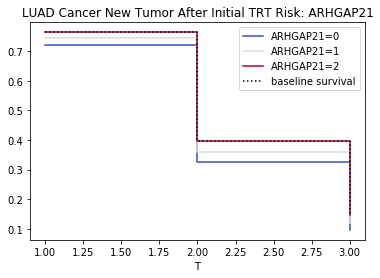

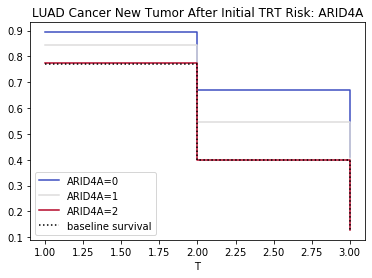

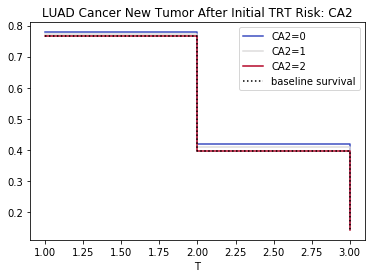

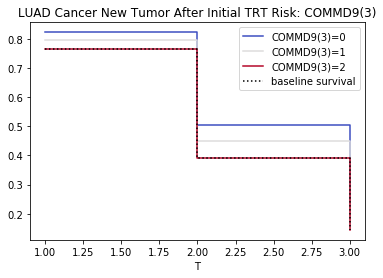

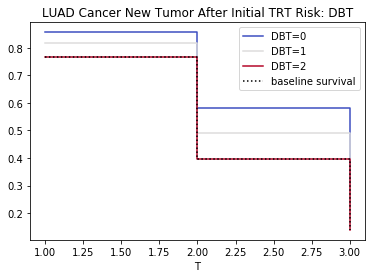

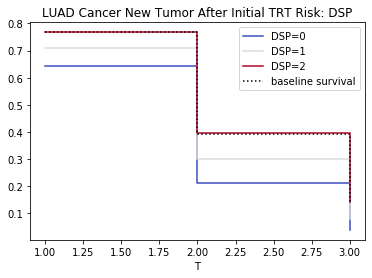

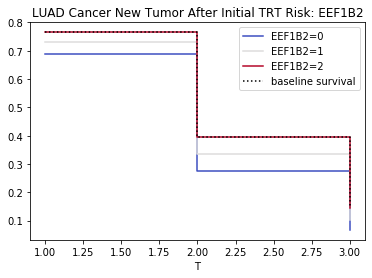

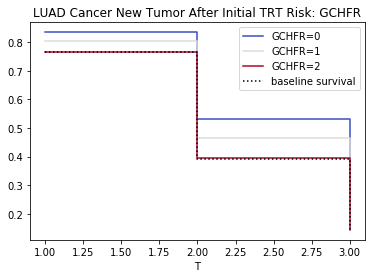

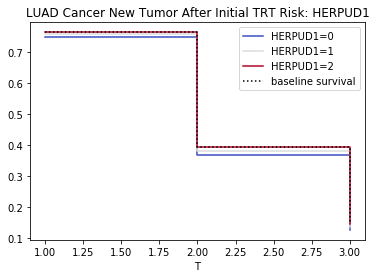

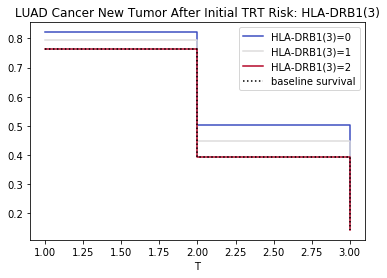

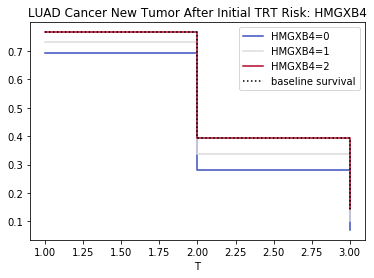

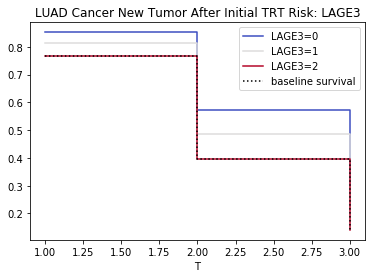

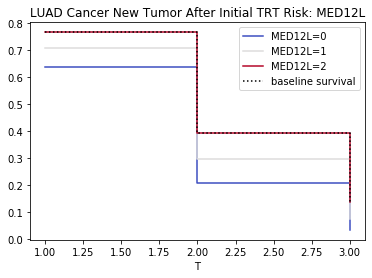

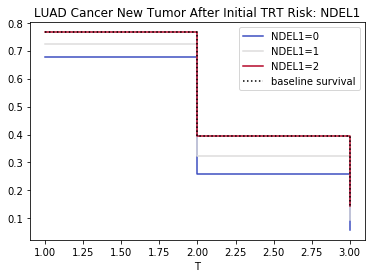

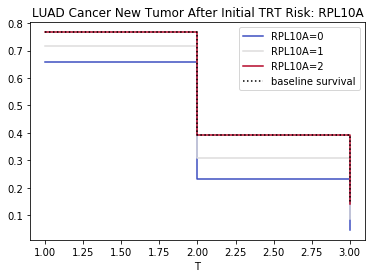

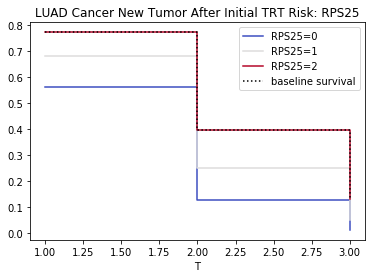

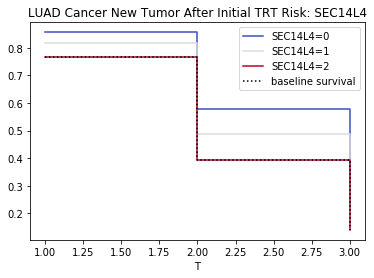

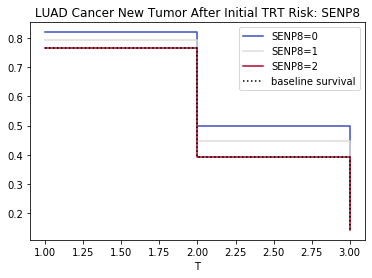

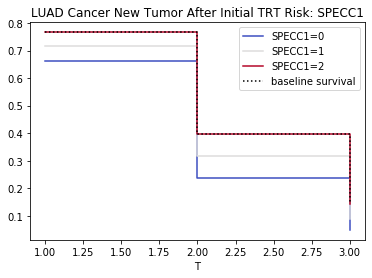

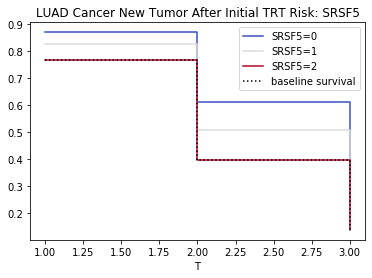

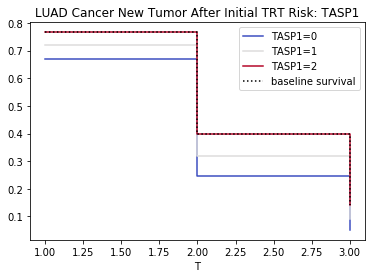

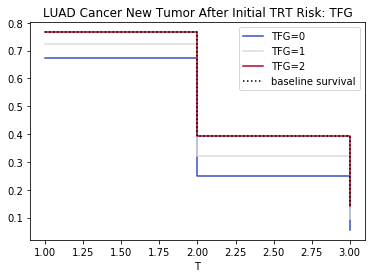

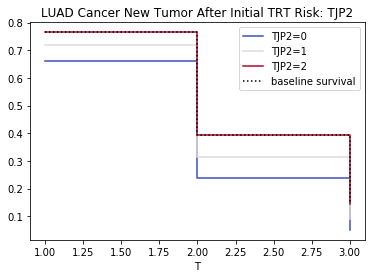

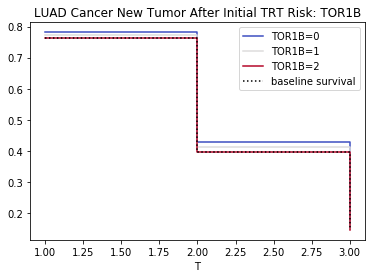

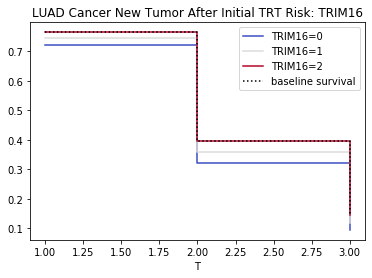

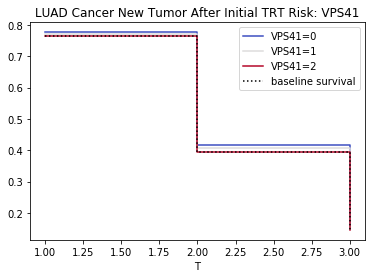

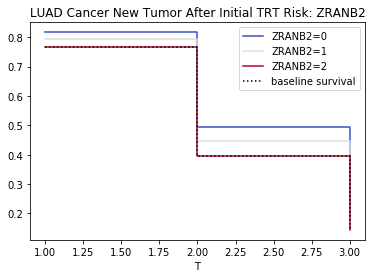

In [14]:
time_col = 'Days_Until_Last_Contact_Or_New_Event'
hazard_genes = []
for gene in sig_genes:
    merged_df = mergeDFs(proteomics, follow_up, gene, 
                         time_to_event=time_to_event, 
                         time_to_last_contact=time_to_last_contact,
                         event_of_interest=event_of_interest)
    merged_df_clean = splitGeneByExpression(gene, merged_df)
    plotMultivariateKaplanMeier(merged_df_clean, time_col, event_of_interest, 
                                luad, hazard_genes, print_summary=True)